# Import 

In [24]:
import numpy as np 
import matplotlib 
from matplotlib import pyplot as plt
import networkx as nx 
import community.community_louvain
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import scipy.stats as stats
import pandas as pd 
from scipy.optimize import fsolve 
import pandas as pd

# Graph Generation 

In [25]:
def part1(partition):
    partition_value=list(partition.values())
    partition_key=list(partition.keys())
    number_of_comm=max(partition_value)+1
    print('number of communities: ', number_of_comm)
    return partition_value, partition_key, number_of_comm

def GraphRelabeling(old_graph, node_labels):
    graph_mat = nx.adjacency_matrix(old_graph, nodelist = node_labels)
    sparse_adj = np.array(graph_mat.todense())
    relabeled_graph = nx.from_numpy_matrix(sparse_adj)
    return sparse_adj, relabeled_graph

def InitialSortingCommunities(partition_value, partition_key, number_of_comm):
    index_comm=[]
    for i in range(0,number_of_comm):
        x=[np.where(np.array(partition_value)==i)[0]]
        index_comm.extend(x) 
    node_list_temp=[]
    size=[]
    for i in range(0,number_of_comm):
        c=np.where(np.array(partition_value)==i)[0]
        size.append(c.size)
        node_list_temp.extend([np.array(partition_key)[c]])
    print("size: ", size)
    print("number of communitis: ", len(size))
    #node_list_old=sorted(node_list_temp,key=len)
    node_list=[]
    for i in range(0, number_of_comm):
        node_list.extend(list(node_list_temp[i]))
    return size, node_list, node_list_temp

def SumOfRCofCommunities(comm_size, B):
    ind_list = [sum(comm_size[:i]) for i in range(0, len(comm_size) + 1)]
    Emp = np.zeros([len(comm_size), len(comm_size)])
    for j in range(0, len(comm_size)): 
        emp = []
        sub_mat = B[ind_list[j]:ind_list[j + 1], :]
        for i in range(0, len(comm_size)):
            emp.append(np.sum(sub_mat[:, ind_list[i]:ind_list[i+1]]))
            #print(emp)
        Emp[j, :] = np.array(emp)
    df = pd.DataFrame(Emp)
    return Emp, df

def BetterPartition(Emp, comm_size): 
    first_row_sum = Emp[0,:]
    n = [i for i in range(0, len(comm_size))]
    myzip =  zip(n[1:], first_row_sum[1:])
    mydictionary = dict(myzip)
    sorted_dict = dict(sorted(mydictionary.items(), key = lambda x: x[1], reverse = True))
    lsorted_dict = list(sorted_dict.keys())
    partition_list = [0] + lsorted_dict
    return partition_list

def RelabelBetterPartion(partition_list, node_list_temp):
    comm_list_new = []
    comm_size_new = []
    for i in partition_list: 
        comm_size_new.append(len(node_list_temp[i]))
        comm_list_new.extend(node_list_temp[i]) 
    return comm_size_new, comm_list_new

# Discounting Functions 

In [26]:
def FindEnemy(x1, x2): 
    """This function finds the enemy indecies for each agent"""
    # sign vector 
    sgn_x1 = np.sign(x1) 
    sgn_x2 = np.sign(x2)  

    # sign matrix 
    sgn_mat_1 = sgn_x1.T * sgn_x1
    sgn_mat_2 = sgn_x2.T * sgn_x2
    sgn_zero =  ~((sgn_mat_1 == 0) | (sgn_mat_2 == 0 )) * 1 
    sgn_mat = ~((sgn_mat_1 > 0) & (sgn_mat_2 > 0 )) * 1 
    sgn_mat_bin = sgn_zero & sgn_mat
    enemy = np.argwhere(sgn_mat_bin == 1)

    return enemy 

# ----------------------------------------------------------# 
def CalculateAngle(x1, x2, enemy): 
    """This function finds the angle between each agent and its enemy"""
    
    # find the enemy for i's
    ix1 = x1[enemy[:, 0]]
    ix2 = x2[enemy[:, 0]]
    
    # find the enemy for j's 
    jx1 = x1[enemy[:, 1]]
    jx2 = x2[enemy[:, 1]]
    
    # concatenate the first and second dim of i's and j's
    ix = np.concatenate((ix1, ix2), 1)
    jx = np.concatenate((jx1, jx2), 1)

    # calculate the unit vector for i's and j's 
    u_ix = UnitVec(ix)
    u_jx = UnitVec(jx)
    
    # calculate the angle in Radian 
    arg = (np.sum(ix * jx, axis = 1))/ (np.linalg.norm(ix, axis = 1) * np.linalg.norm(jx, axis = 1))
    angle = np.arccos(np.clip(arg, -1, 1))
    return angle

# ----------------------------------------------------------# 

def UnitVec(vec):
    return vec / np.linalg.norm(vec) 

# ----------------------------------------------------------# 

def CalculateF(angle, d, beta):
    """This function calculates the value of the discouting function"""
#     d = 0.5
#     beta = 1.5
#     F_angle  = (-1 / np.pi) * np.abs(angle) + 1
    F_angle = (1 - (1-d)  * (np.abs((1 / np.pi) * angle) ** beta))
    
    
    return F_angle 

# ----------------------------------------------------------# 

def DiscountWeightMatrix(enemy, F_angle, W): 
    """This function discounts each element of the weight matrix according to the enemy's indicies"""
    
    W[enemy[:, 0], enemy[:, 1]] = np.copy(W[enemy[:,0], enemy[:, 1]] * F_angle)
    return W

# ----------------------------------------------------------# 
def ApplyProcedure(x1, x2, W, d, beta):
    """This function finds the enemies, calculates \theta, and f(\theta) and discounts the weight matrix"""
    
    enemy = FindEnemy(x1, x2)
    angle = CalculateAngle(x1, x2, enemy)
    F_angle = CalculateF(angle, d, beta)
    Wdiscounted = DiscountWeightMatrix(enemy, F_angle, W)
    return Wdiscounted
# ----------------------------------------------------------# 
def UpdateRuleMultiFurmula(Wd, x):
    """For each dimension, updates the states"""
    Wp = Wd - np.diag(np.diag(Wd))
    abs_x = abs(x)
    diag_abs_x = np.diagflat(abs_x) 
    diag_x = np.diagflat(x)
    sgn_x = np.sign(x)
    # (4*1) + (4*4) * (4*4) * (4*1) - (4*4) * (4*4) * (4*1) 
    xp = x + Wp @ diag_abs_x @ sgn_x - diag_x @ Wp @ abs_x
    return xp
# ----------------------------------------------------------# 

def UpdateRuleMulti(W, x1, x2,  d, beta):  
    """This function receives W with bubble property, dicounts the weight matrix and calculates the next iteration of 
    first and second dim of x """
    
    # discounted weight matrix 
    Wd = ApplyProcedure(x1, x2, W,  d, beta)  
    
    # dim 1 
    xp1 = UpdateRuleMultiFurmula(Wd, x1)
#     print(xp1)
    
    # dim 2 
    xp2 = UpdateRuleMultiFurmula(Wd, x2)

    return xp1, xp2 

# Auxialliary Functions 

In [27]:
def PossibleInteGraph(NodesNum, pL, AG):
    RandInt = np.random.rand(NodesNum, NodesNum)
    Smaller = (RandInt <= pL) * 1
    Bigger = (RandInt >= (pL)) * 1
    InteGraph = (Smaller * (1) + Bigger * (0)) * AG
    return InteGraph
# ----------------------------------------------------------# 
def checkSum(arr,value):
    if np.prod(arr<=value):
        ok=1
        ind=[]
    else:
        ok=0
        ind=np.where(arr>value)
    return ok,ind
# ----------------------------------------------------------# 
def Adjacency(G):
    B = nx.adjacency_matrix(G)
    AG=np.array(B.todense())
    return AG
# ----------------------------------------------------------# 
def WhatIsAlpha(gamma_B, want_plot = False): 
    FONT_Size = 14
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = FONT_Size
    plt.rcParams['font.family'] = "serif"
    plt.rcParams['font.serif']= "Computer Modern"
    
    """This funtion calculates alpha_1 and alpha_2 in addition to minG and argMinG"""
    arg = lambda a: (1 - a) / np.sqrt((2) * (a ** 2 + 1))
    theta = lambda a: np.arccos(np.clip(arg(a), -1, 1))
    f = lambda a:  (1 - (1 - d) * (theta(a) / np.pi) ** beta)
    func = lambda a: gamma_B - f(a) * (1 + a) / (a * (1 - a))

    initial_guess = [EPSILON, 1 - EPSILON] 
    solution = fsolve(func, initial_guess)
    alpha_1 = round(min(solution), digits_to_round)
    alpha_2 = round(max(solution), digits_to_round)
    
    inv = gamma_B - func(a) 
    minG = round(min(inv), digits_to_round)
    argMinG = round(a[np.argmin(inv)], digits_to_round)
    
    print('alpha_1: ', alpha_1)
    print('alpha_2: ', alpha_2)
    print('minG: ', minG)
    print('argminG: ', argMinG)
    plt.figure(figsize=[6,4.5])
    if want_plot == True: 
#         plt.figure(figsize = [4, 3])
        plt.figure(figsize=[6,4.5])
        plt.plot(a, inv, color = 'black', label = r'$\frac{f(\theta) (1 + a)}{a(1 - a)}$')
        plt.xlim(0, 1)
        plt.ylim(0, 10)
        vec = np.ones([len(a)])
        plt.plot(a, gamma_B * vec, color = 'green', label = r'$\gamma_\mathcal{B}$')
        plt.scatter(alpha_1, gamma_B, color = 'blue', label = r'$\alpha_1$')
        plt.scatter(alpha_2, gamma_B, color = 'red', label = r'$\alpha_2$')
        plt.xlabel(r'$\alpha$')
        plt.ylabel(r'$\gamma_\mathcal{B}$')
        plt.legend(loc='upper center', bbox_to_anchor = (0.5, 1), prop={'size': FONT_Size}, frameon = 1, ncol = 2)
        plt.show()
        
    return alpha_1, alpha_2, minG, argMinG
# ----------------------------------------------------------# 
def TimeBubble(bubble, alpha1, alpha2, size, whichB):
  ## bubble (+)
  if all(bubble[-1]>=0):

    ## (t0)
    index0TFB=(bubble>=1*alpha1)*1
    MatBIndex0=np.dot(index0TFB,np.ones([size,1]))
    t0B=np.min(np.where(MatBIndex0==size)[0])

    ## (tf)
    indexfTFB=(bubble>=1*alpha2)*1
    MatBIndexf=np.dot(indexfTFB,np.ones([size,1]))
    tfB=np.min(np.where(MatBIndexf==size)[0])
    index=1

    #print
    print('+Up+')
    print(f'index{index}=', index)
    print(f't0B{whichB}=',t0B, f', tfB{whichB}=', tfB)
    

  ## bubble (-)
  elif all(bubble[-1]<=0):

    ## (t0)
    index0TFB=(bubble<=-1*alpha1)*1
    MatBIndex0=np.dot(index0TFB,np.ones([size,1]))
    t0B=np.min(np.where(MatBIndex0==size)[0])

    ## (tf)
    indexfTFB=(bubble<=-1*alpha2)*1
    MatBIndexf=np.dot(indexfTFB,np.ones([size,1]))
    tfB=np.min(np.where(MatBIndexf==size)[0])
    index = -1

    # print
    print('-Down-')
    print(f'index{index}=', index)
    print(f't0B{whichB}=',t0B, f', tfB{whichB}=', tfB)

    # result
  return t0B, tfB, index

# Bubble Property Functions 

In [28]:
def RatioCorrectionPC_Opt(h, sumh1, sumh1Out, s1, s2, CoeffBd, i):
    
    ratio_h1 = np.ones(np.shape(sumh1))

    arr1 = (sumh1 == 0)
    arr2 = (sumh1Out == 0)

    arr1n = np.invert(arr1)
    arr2n = np.invert(arr2)

    zh1 = np.where( arr1 & arr2n )[0] #a=0, b!=0

    zh1Out = np.where( arr1n & arr2)[0] #a=0, b!=0  

    zh1Both = np.where( arr1 & arr2 )[0] #a=0, b=0

    zh1NotBoth = np.where(arr1n & arr2n)[0]  #a!=0, b!=0

    if np.size(zh1)!= 0: #a=0, b~=0
      #the first worst case: a=0, b~=0--> we have to force b to be zero, to maintain bubble property 
      h = BubbleForcingCase2(h, zh1, sumh1, s1, s2, i)#forcing those who are out of bubbles (b) to be zero.
      #ratio correction
      ratio_h1[zh1] = np.zeros((len(zh1),1)) #make sure the ratio is zero

    if np.size(zh1Both)!= 0: #a=0, b=0
      #the second (worst) case: a=b=0-> we only have to modify the ratio, 
      #so that no errors such "zero division" arise.

      #ratio correction
      ratio_h1[zh1Both] = np.zeros((len(zh1Both),1))
    
    if np.size(zh1Out) != 0: #a!=0, b=0
      #the third case: where a!=0, b=0
      ratio_h1[zh1Out] = np.ones((len(zh1Out),1))

    if np.size(zh1NotBoth) != 0: #a!=0, b!=0
      #the first case:  a!=0,b!=0 
      ratio_h1[zh1NotBoth] = (CoeffBd + 0.002) * (sumh1Out[zh1NotBoth] / sumh1[zh1NotBoth])
    return h, ratio_h1

# ----------------------------------------------------------# 

def BubbleForcingCase2(h,h1Only,sumh1,s1,s2,i):
    ONEz=np.ones(len(sumh1),)
    ONEz[h1Only]=np.zeros(len(h1Only),)
    if i==1:
        h[0:s1,:]=np.copy(np.dot(np.diag(ONEz),h[0:s1,:]))
    if i==2:
        h[s1:,:]=np.copy(np.dot(np.diag(ONEz),h[s1:,:]))
    return h

# ----------------------------------------------------------# 


def CheckRatioPC_Opt(sum1,sum2, CoeffBd):
    notif=np.ones(len(sum1),)
    arr1 = (sum1 == 0)
    arr2 = (sum2 == 0)
    arr1n = np.invert(arr1)
    arr2n = np.invert(arr2)
    Only = np.where( arr1 & arr2n )[0] #a=0, b!=0
    OutOnly = np.where( arr1n & arr2)[0] #a=0, b!=0  
    BothOnly = np.where( arr1 & arr2 )[0] #a=0, b=0
    NotBothOnly = np.where(arr1n & arr2n)[0]  #a!=0, b!=0

    if np.size(Only)!= 0:
        notif[Only] = np.zeros(len(Only),)
        
    if np.size(OutOnly)!=0:
        notif[OutOnly] = np.ones(len(OutOnly),)

    if np.size(BothOnly)!=0:
        notif[BothOnly] = np.ones(len(BothOnly),)
    
    if np.size(NotBothOnly)!=0:
        RATIO = sum1[NotBothOnly] / sum2[NotBothOnly]
        RATIO_Check = (RATIO >= CoeffBd)
        
        if False in RATIO_Check:
            whereZ = np.where(RATIO_Check * 1 == 0)[0]
            notif[whereZ] = np.zeros(len(whereZ),)
    arr = np.array([])
    if False in notif:
        notification = 0
        arr = np.where(notif == 0)[0]
    else: 
        notification = 1
    return notification, arr

# ----------------------------------------------------------# 

In [105]:
def GenerateAdjPC_v0(hg, GammaB, NodesNum, ti, comm_size):
        
    #  ratio correction: 
    #  those who are in B1/ those who are not in B1 
         # main definition for bubbles 
    GammaB1=GammaB[0] 
    #GammaB for bubble 1, \gamma_{\B_1}
    GammaB2=GammaB[1] 
    #GammaB for bubble 2, \gamma_{\B_2}

    s1,s2=S1S2(comm_size)
    
    hgB1=hg[0:s1,0:s1] 
    #weight of i,i \in \B_1
    hgB1Not=hg[0:s1,s1:] 
    #weight of i \in \B_1 and j \notin \B_1

    hgB2=hg[s1:,s1:] 
    #weight of i,i \in \B_2
    hgB2Not=hg[s1:,0:s1] 
    #weight of i \in \B_2 and j \notin \B_2

    SumVecB1=np.sum(hgB1, axis=1, keepdims=True) 
    #row weight sum of i \in \B_1
    SumVecB1Not= np.sum(hgB1Not, axis=1, keepdims=True) 
    #row weight sum of i \in \B_1, \j \notin\B1, \sgn(x_i) \neq \sgn(x_j)
    
    SumVecB2=np.sum(hgB2, axis=1, keepdims=True) #row weight sum of i \in \B_2
    SumVecB2Not= np.sum(hgB2Not, axis=1, keepdims=True) 
    #row weight sum of i \in \B_2, \j \notin\B2, \sgn(x_i) \neq \sgn(x_j)

    hg,ratio_h1=RatioCorrectionPC_Opt(hg,SumVecB1,SumVecB1Not,s1,s2,GammaB1,1) #k=1
    hg,ratio_h2=RatioCorrectionPC_Opt(hg,SumVecB2,SumVecB2Not,s1,s2,GammaB2,2) #k=2

    hg[0:s1,0:s1]=np.copy(ratio_h1*hg[0:s1,0:s1]) #k=1
    hg[s1:,s1:]=np.copy(ratio_h2*hg[s1:,s1:]) #k=2



    # normalization to get \forall i \in \N \sum_{w_{ij}(t)} <=1
    norm=np.sum(hg,axis=1,keepdims = True)
    Hn=(1/(norm + 1))*hg  
    sumHn=np.sum(Hn,axis=1,keepdims = True)
    notifHn,arrHn=checkSum(sumHn,1)

    #checking the bubble property 
    HnB1=Hn[0:s1,0:s1]
    HnB1Not=Hn[0:s1,s1:]

    HnB2=Hn[s1:,s1:]
    HnB2Not=Hn[s1:,0:s1]
    
    sumB1=np.sum(HnB1,axis=1,keepdims = True)
    sumHnB1Not=np.sum(HnB1Not,axis=1,keepdims = True)

    sumB2=np.sum(HnB2,axis=1,keepdims = True)
    sumHnB2Not=np.sum(HnB2Not,axis=1,keepdims = True)

    notif1,arr1=CheckRatioPC_Opt(sumB1,sumHnB1Not,GammaB1)
    notif2,arr2=CheckRatioPC_Opt(sumB2,sumHnB2Not,GammaB2)

    notif=[notif1,notif2]
    arr=[arr1,arr2]

    if notif == [0,0]:
        print('due to B={}, B={} for t={}'.format(1,2,ti))
        print('for B={} in row:'.format(1))
        print(arr1)
        print('for B={} in row:'.format(2))
        print(arr2)

    elif not notif == [0,0] and not notif == [1,1]:
        print('Bubble Property did not satisfied for t={}'.format(ti))
        if notif == [0,1]:
            print('due to B={} for t={}'.format(1,ti))
            print('in row:')
            print(arr1)
        elif notif == [1,0]:
            print('due to B={} for t={}'.format(2,ti))
            print('in row:')
            print(arr2)
        #print('--------------------------------------')
        #print(' ')
    return Hn, notifHn, arrHn, notif, arr
# ----------------------------------------------------------# 

# Normal Initial Condition 

In [31]:
def X0NormalDistribution(NodesNum, comm_size, GammaB, mu, sigma):
    s1,s2=S1S2(comm_size)

    range_1=range(0,s1)
    range_2=range(s1,NodesNum)

    NB1=s1
    NB2=NodesNum-s1
    muB1=mu[0]
    muB2=mu[1]

    sigmaB1=sigma[0]
    sigmaB2=sigma[1]

    X0=np.zeros((NodesNum))

    # exteract N samples from a normal distribution 
    lower, upper = -1, 1
    X0[range_1] = stats.truncnorm((lower - muB1)/sigmaB1, (upper - muB1)/sigmaB1, loc=muB1, scale=sigmaB1).rvs(NB1)
    X0[range_2] = stats.truncnorm((lower - muB2)/sigmaB2, (upper - muB2)/sigmaB2, loc=muB2, scale=sigmaB2).rvs(NB2)
    return X0


# Main Dynamics 

In [104]:
def PCDyanmics(NodesNum, Gnew, comm_size, GammaB, pL, WeightCoeff, t, mu_d1, mu_d2, sigma_d1,\
       sigma_d2,  d, beta):
    AG = Adjacency(Gnew)
    X1 = np.zeros((NodesNum, t+1))
    X2 = np.zeros((NodesNum, t+1))
    X10 = X0NormalDistribution(NodesNum, comm_size, GammaB, mu_d1, sigma_d2).reshape((NodesNum))
    X20 = X0NormalDistribution(NodesNum, comm_size, GammaB, mu_d2, sigma_d2).reshape((NodesNum))

    for i in range(1, t+1):
        if (i == 1):
            X1[:,i-1] = X10
            X2[:,i-1] = X20
        InteGraph = PossibleInteGraph(NodesNum, pL, AG)
        h = np.random.rand(NodesNum, NodesNum)
        hg = (WeightCoeff) * np.multiply(h, InteGraph)
        currentX1 = X1[:,i-1].reshape((NodesNum, 1))
        currentX2 = X2[:,i-1].reshape((NodesNum, 1))
        Hn, okB, indB, okHn, indHn = GenerateAdjPC_v0(hg, d, GammaB, InteGraph, NodesNum, ti, comm_size)
        Hnw = (WeightCoeff) * Hn
        y1, y2 = UpdateRuleMulti(Hn, currentX1, currentX2,  d, beta)
        X1[:,i] = y1.reshape((NodesNum))
        X2[:,i] = y2.reshape((NodesNum))
    return X1, X2

# Plot Functions 

In [33]:
def PlusOrMinus(index):
    if index == 1: 
        char = '+'
    else: 
        char = '-'
    return char 
# ----------------------------------------------------------# 

# adjust matplotlib parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif']= "Computer Modern"

def PLot(bubbe1, bubble2, tfB1, t0B1, t0B2, tfB2, index_B1, index_B2, name):
    
    color1='#7c2a20'
    color2='#34475b'
    color3='#cd8f87'
    color4='#8799aa'
    
    mylinestyleB='-'
    mylinestyleM='-'
    FONT=15
    linewidthM=2.5
    linewidthB=1


    plt.figure(figsize=[8,6])
    plt.plot(bubble1[0:(tStop+1)][:] ,color=color1, linestyle = mylinestyleB, linewidth=linewidthB)
    plt.plot(bubble2[0:(tStop+1)][:], color=color2, linestyle = mylinestyleB, linewidth=linewidthB)

    MedianB1=np.median(bubble1[0:(tStop+1)][:],axis=1)
    MedianB2=np.median(bubble2[0:(tStop+1)][:],axis=1)

    plt.plot(MedianB1, color=color3, linestyle = mylinestyleM, linewidth=linewidthM)
    plt.plot(MedianB2, color=color4, linestyle = mylinestyleM, linewidth=linewidthM)

    plt.xlabel(r"$t$", fontsize=FONT)
    plt.ylabel(r"$X(t)$", fontsize=FONT)

    Parts=100

    x1LineB1=np.linspace(t0B1,Parts+t0B1-1,Parts)
    x2LineB1=np.linspace(tfB1,Parts+tfB1-1,Parts)

    x1LineB2=np.linspace(t0B2,Parts+t0B2-1,Parts)
    x2LineB2=np.linspace(tfB2,Parts+tfB2-1,Parts)

    yline=np.ones(Parts)

    plt.plot(x1LineB1, index_B1*alpha1_B1*yline, color='black', linestyle='-', linewidth=2)
    plt.plot(x2LineB1, index_B1*alpha2_B1*yline, color='black', linestyle='-', linewidth=2)

    plt.plot(x1LineB2, index_B2*alpha1_B2*yline, color='black', linestyle='-', linewidth=2)
    plt.plot(x2LineB2, index_B2*alpha2_B2*yline, color='black', linestyle='-', linewidth=2)


    patch1 = mpatches.Patch(color=color1, linestyle = mylinestyleB, label=r'$\mathcal{B}_1$')
    patch2 = mpatches.Patch(color=color2, linestyle = mylinestyleB, label=r'$\mathcal{B}_2$')
    patch3 = mpatches.Patch(color=color3, linestyle = mylinestyleM, label=r'$Med(\mathcal{B}_1)$')
    patch4 = mpatches.Patch(color=color4, linestyle = mylinestyleM, label=r'$Med(\mathcal{B}_2)$')

    plt.legend(handles=[patch1, patch2, patch3, patch4], prop={'size': FONT}, loc='upper center',
               bbox_to_anchor=(0.5, 1.15), frameon=1, ncol=4) 

    espU=0.05
    espD=-0.08
    move=-15
    props = dict(boxstyle='round', facecolor='white', alpha=0.9)

    plt.text(t0B1, index_B1*alpha1_B1+espU, r'$\alpha_1$ for $\mathcal{B}_1$', fontsize=FONT,  color=color1, bbox=props)
    plt.text(tfB1, index_B1*alpha2_B1+espU, r'$\alpha_2$ for $\mathcal{B}_1$', fontsize=FONT,  color=color1, bbox=props)

    plt.text(t0B2, index_B2*alpha1_B2+espU, r'$-\alpha_1$ for $\mathcal{B}_2$', fontsize=FONT,  color=color2, bbox=props)
    plt.text(tfB2, index_B2*alpha2_B2+espU, r'$-\alpha_2$ for $\mathcal{B}_2$', fontsize=FONT,  color=color2, bbox=props)


    plt.rcParams.update({'font.size':FONT})
    plt.ylim(-1,1)
    plt.xlim(0,tStop)
    plt.grid(color='#e1e0e1', linestyle='-', linewidth=2)
    plt.savefig(name, format='pdf', dpi = 700)
    plt.show()
    
# ----------------------------------------------------------# 

    
def TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line):
    FONT=10
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = FONT
    plt.rcParams['font.family'] = "serif"
    plt.rcParams['font.serif']= "Computer Modern"
    color1 = '#7c2a20'
    color2 = '#34475b'
    
    if text_color == 'red': 
        text_color = color1
    elif text_color == 'blue':
        text_color = color2
     
    sizeS = 5

    plt.figure(figsize=[6,4.5])

    patch1 = mpatches.Patch(color=color1, label=r'$\mathcal{B}_1$')
    patch2 = mpatches.Patch(color=color2, label=r'$\mathcal{B}_2$')
    
    plt.legend(handles=[patch1, patch2], prop={'size': FONT}, loc='upper center', bbox_to_anchor=(0.5,1.1),
               frameon=1, ncol=2)

    plt.scatter(data_B1_dim_1, data_B1_dim_2 ,color = color1, s=sizeS, marker=".")
    plt.scatter(data_B2_dim_1, data_B2_dim_2, color = color2, s=sizeS, marker=".")

    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(r'$x^{(1)}$')
    plt.ylabel(r'$x^{(2)}$')
    
    if timing != 0 and timing != 1000:  
        if line == 'Horizontal': 
            xv, yv  = HorizontalLinePlot(signForLine * ALPHA)
        elif line == 'Vertical':
            xv, yv  = VerticalLinePlot(signForLine * ALPHA)
        plt.plot(xv, yv, color='black', linestyle = '-', linewidth = 1)
        plt.text(text_x, text_y, text, fontsize = FONT,  color = text_color)
        plt.savefig(name, format='pdf', dpi = 300) 
        plt.show()

    else:
        plt.savefig(name, format='pdf', dpi = 300) 
        plt.show()


# Test

In [94]:
NodesNum=500
pGt=np.log(NodesNum)/NodesNum
ep=0.05
pG=pGt+ep
print('pGt:', pGt, ", pG:", pG)

G=nx.erdos_renyi_graph(NodesNum, pG, seed=None, directed=False)
partition = community.community_louvain.best_partition(G)
partition_value, partition_key, number_of_comm=part1(partition)

size, node_list, node_list_temp = InitialSortingCommunities(partition_value, partition_key, number_of_comm)
B, G1 = GraphRelabeling(G, node_list)
Emp, df = SumOfRCofCommunities(size, B)

better_partition = BetterPartition(Emp, size)
comm_size_new, comm_list_new = RelabelBetterPartion(better_partition, node_list_temp)
B2, G2 = GraphRelabeling(G1, comm_list_new)

pGt: 0.012429216196844383 , pG: 0.062429216196844384
number of communities:  9
size:  [33, 51, 54, 68, 76, 66, 52, 45, 55]
number of communitis:  9


In [107]:
def S1S2(comm_size):
  div=4
  s1=np.sum(comm_size[0:div])
  s2=s1+np.sum(comm_size[div:])
  return s1,s2

s1,s2=S1S2(comm_size_new)
print('B1:{}, B2:{}'.format((s1),(NodesNum-(s1))))

B1:243, B2:257


Bubble 1
alpha_1:  0.2849
alpha_2:  0.631
minG:  4.0559
argminG:  0.4523


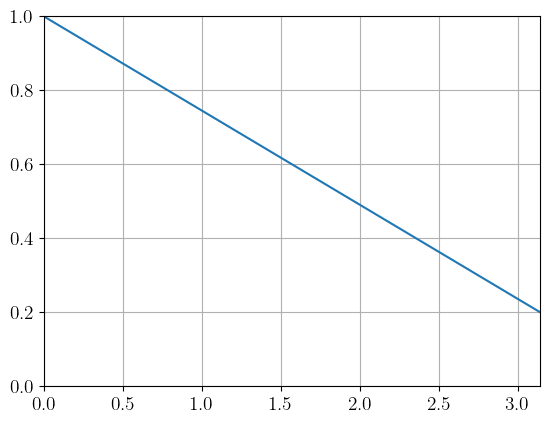

<Figure size 600x450 with 0 Axes>

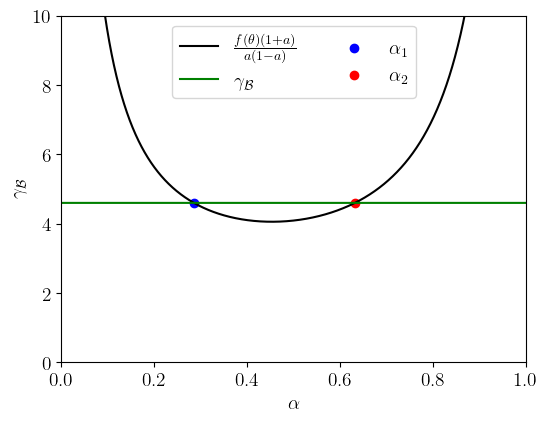

--------
Bubble 2
alpha_1:  0.2615
alpha_2:  0.6577
minG:  4.0559
argminG:  0.4523


<Figure size 600x450 with 0 Axes>

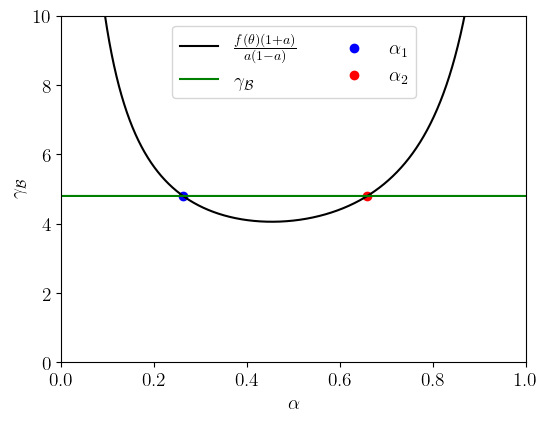

In [108]:
GammaB1 = 4.6
GammaB2 = 4.8
GammaB = [GammaB1, GammaB2]
EPSILON = 10 ** (-1)
PERCISION = 10 ** (2)
digits_to_round = 4

d = 0.2
beta  = 1
a = np.linspace(0.001, 0.999, 2000)
theta = np.linspace(0, np.pi, 100)
f_theta = 1 - (1 - d) * (theta / np.pi) **(beta)
plt.plot(theta, f_theta)
plt.xlim(0, np.pi)
plt.ylim(0, 1)
plt.grid()
print('Bubble 1')
alpha1_B1, alpha2_B1, minG_B1, argminG_B1 = WhatIsAlpha(GammaB1, want_plot = True)
print('--------')
print('Bubble 2')
alpha1_B2, alpha2_B2, minG_B2, argminG_B2 = WhatIsAlpha(GammaB2, want_plot = True)

In [109]:
# #weights coefficient
WeightCoeff = 0.018
print('weightCoeff:', WeightCoeff)
# probability of asynchronous interaction 
pL = 0.8
print('probability of asynchronous interaction: ', pL)

# time 
t = 1000

mu_d1 =[-0.09, 0.08]
mu_d2 =[0.07, - 0.09]
sigma2_d1_B1, sigma2_d1_B2= 0.12,  0.14
sigma2_d2_B1, sigma2_d2_B2= 0.14,  0.13


sigma_d1 = [np.sqrt(sigma2_d1_B1), np.sqrt(sigma2_d1_B2)]
sigma_d2 = [np.sqrt(sigma2_d2_B1),np.sqrt(sigma2_d2_B2)]

print('mu_d1: ', mu_d1)
print('mu_d2: ', mu_d2)
print('sigma_d1: ', sigma_d1)
print('sigma_d2: ', sigma_d2)

print('Information')
print('----------------')
print('B1:{}, B2:{}'.format((s1),(NodesNum-(s1))))
print('GammaB1', GammaB1)
print('GammaB2', GammaB2)
print(f'alpha1_B1:{alpha1_B1}, alpha2_B1: {alpha2_B1}')
print(f'alpha1_B1:{alpha1_B2}, alpha2_B1: {alpha2_B2}')
print('mu_B1 = {}, mu_B2 = {}'.format(mu_d1, mu_d2))
print(f'sigma2_d1_B1 = {sigma2_d1_B1}, sigma2_B2 = {sigma2_d1_B2}')
print(f'sigma2_d2_B1 = {sigma2_d2_B1}, sigma2_B2 = {sigma2_d2_B2}')
# print(f'd = {d}')
print(f'WeightCoeff = {WeightCoeff}')
print(f'pL = {pL}')
print(f'pG = {round(pG, 4)}')
# print(f'beta = {beta}')
print(f't = {t}')
print('----------------')

weightCoeff: 0.018
probability of asynchronous interaction:  0.8
mu_d1:  [-0.09, 0.08]
mu_d2:  [0.07, -0.09]
sigma_d1:  [0.34641016151377546, 0.37416573867739417]
sigma_d2:  [0.37416573867739417, 0.36055512754639896]
Information
----------------
B1:243, B2:257
GammaB1 4.6
GammaB2 4.8
alpha1_B1:0.2849, alpha2_B1: 0.631
alpha1_B1:0.2615, alpha2_B1: 0.6577
mu_B1 = [-0.09, 0.08], mu_B2 = [0.07, -0.09]
sigma2_d1_B1 = 0.12, sigma2_B2 = 0.14
sigma2_d2_B1 = 0.14, sigma2_B2 = 0.13
WeightCoeff = 0.018
pL = 0.8
pG = 0.0624
t = 1000
----------------


In [102]:
X1, X2 = PCDyanmics(NodesNum, G2, comm_size_new, GammaB, pL, WeightCoeff, t, mu_d1, mu_d2, sigma_d1,\
       sigma_d2,  d, beta)


# X1 [agents, time]
# X1^t [time, agents]

In [110]:
bubble1_t1 = np.transpose(X1)[:, 0:s1]
bubble1_t2 = np.transpose(X2)[:, 0:s1]

bubble2_t1 = np.transpose(X1)[:, s1:]
bubble2_t2 =np.transpose(X2)[:, s1:]

# Plot Results 

In [113]:
t0B1_t1, tfB1_t1, index_B1_t1= TimeBubble(bubble1_t1, alpha1_B1, alpha2_B1, s1, 1)
print('-----------------')
t0B2_t1, tfB2_t1, index_B2_t1= TimeBubble(bubble2_t1, alpha1_B2, alpha2_B2, s2-s1, 2)
print('-----------------')

-Down-
index-1= -1
t0B1= 504 , tfB1= 619
-----------------
+Up+
index1= 1
t0B2= 614 , tfB2= 748
-----------------


In [114]:
t0B1_t2, tfB1_t2, index_B1_t2= TimeBubble(bubble1_t2, alpha1_B1, alpha2_B1, s1, 1)
print('-----------------')
t0B2_t2, tfB2_t2, index_B2_t2= TimeBubble(bubble2_t2, alpha1_B2, alpha2_B2, s2-s1, 2)
print('-----------------')

-Down-
index-1= -1
t0B1= 873 , tfB1= 925
-----------------
-Down-
index-1= -1
t0B2= 455 , tfB2= 522
-----------------


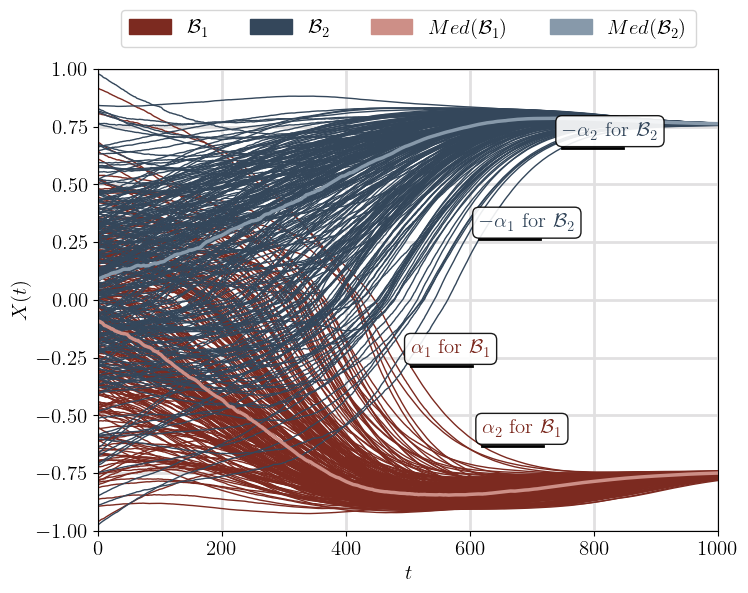

In [116]:
# bubble1, bubble2 = bubble1_t1, bubble2_t1
# tfB1, t0B1, t0B2, tfB2 = tfB1_t1, t0B1_t1, t0B2_t1, tfB2_t1
# index_B1, index_B2 = index_B1_t1, index_B2_t1
# name = r'MPC_topic_1.pdf'
# PLot(bubble1, bubble2, tfB1, t0B1, t0B2, tfB2, index_B1, index_B2, name)

bubble1, bubble2, tfB1, t0B1, t0B2, tfB2 = bubble1_t1, bubble2_t1, tfB1_t1, t0B1_t1, t0B2_t1, tfB2_t1
index_B1, index_B2 = index_B1_t1, index_B2_t1
name = 'MDPC_topic 1.pdf'
PLot(bubble1, bubble2, tfB1, t0B1, t0B2, tfB2, index_B1, index_B2,name)

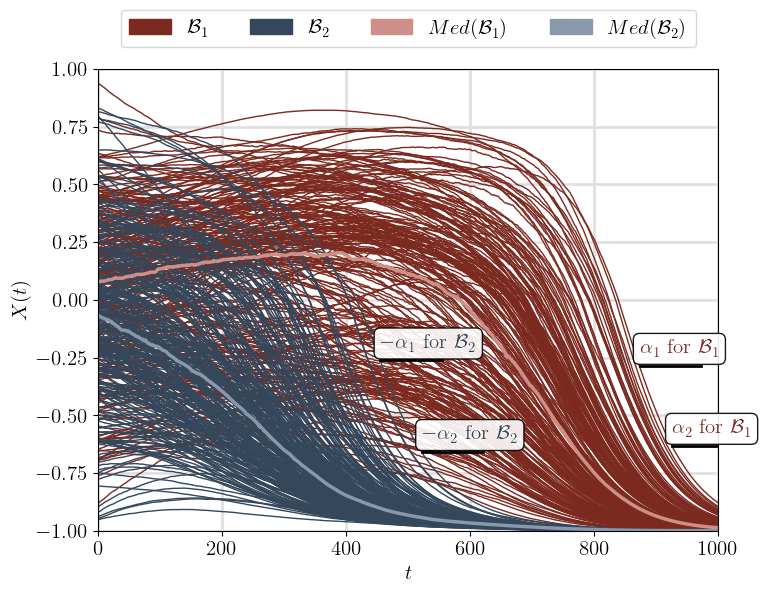

In [117]:
# bubble1, bubble2 = bubble1_t2, bubble2_t2
# tfB1, t0B1, t0B2, tfB2 = tfB1_t2, t0B1_t2, t0B2_t2, tfB2_t2
# index_B1, index_B2 = index_B1_t2, index_B2_t2
# name = r'MPC_topic_1.pdf'
# PLot(bubble1, bubble2, tfB1, t0B1, t0B2, tfB2, index_B1_t2, index_B2_t2, name)

tStop = t
bubble1, bubble2 = bubble1_t2, bubble2_t2
tfB1, t0B1, t0B2, tfB2 = tfB1_t2, t0B1_t2, t0B2_t2, tfB2_t2
index_B1, index_B2 = index_B1_t2, index_B2_t2
name = 'MDPC_topic 2.pdf'
PLot(bubble1, bubble2, tfB1, t0B1, t0B2, tfB2, index_B1, index_B2, name)

# 2d plot

In [121]:
# Vertical line 
# x constant 
# y variable 
def VerticalLinePlot(scale):
    Parts = 100
    xv = scale * np.ones([Parts,1])
    yv = np.linspace(-1, 1, Parts)
    return xv, yv
def HorizontalLinePlot(scale): 
    Parts = 100
    xh = np.linspace(-1, 1, Parts)
    yh = scale * np.ones([Parts,1])
    return xh, yh

## Bubble 1

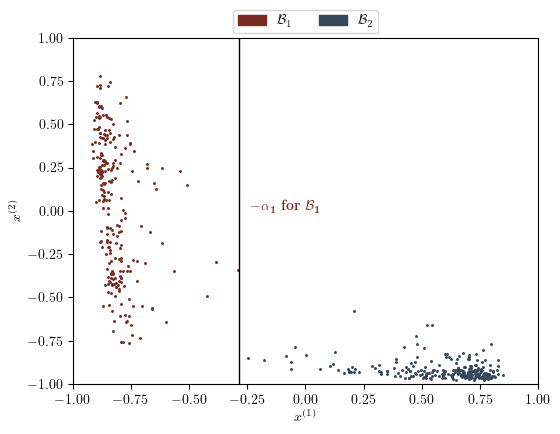

In [123]:
# topic 1
# bubble 1
# t0B1_t1 (alpha 1)

timing = t0B1_t1
name = 'topic_1_Bubble_1_alpha_1.pdf'

ALPHA = alpha1_B1
plot_color = 'red'
signForText = -1 
signForLine = -1

sep = 0.05 

text_x = -alpha1_B1 + sep
text_y = 0 
text = r'$\mathbf{-\alpha_1}$ \textbf{for} $\mathbf{' + '\mathcal{B}_1}$'

text_color = 'red' 
line = 'Vertical'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


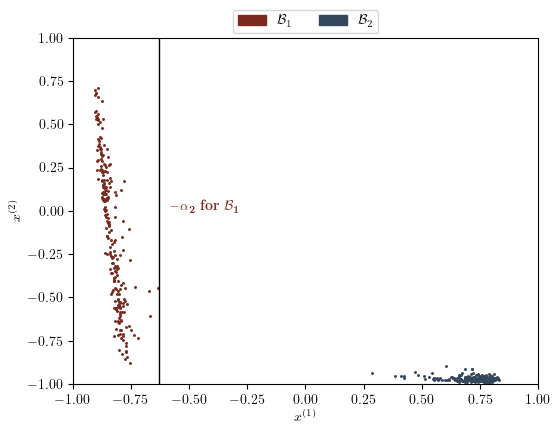

In [124]:
# topic 1
# bubble 1
# tfB1_t1 (alpha 2)

timing = tfB1_t1
name = 'topic_1_Bubble_1_alpha_2.pdf'

ALPHA = alpha2_B1
plot_color = 'red'
signForText = -1 
signForLine = -1

sep = 0.05 

text_x = -alpha2_B1 + sep
text_y = 0

text = r'$\mathbf{-\alpha_2}$ \textbf{for} $\mathbf{' + '\mathcal{B}_1}$'

text_color = 'red' 
line = 'Vertical'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


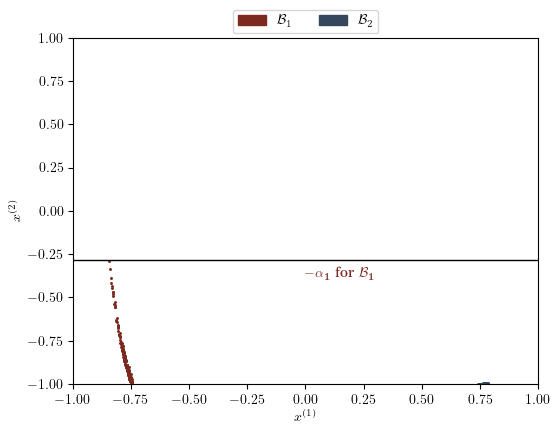

In [126]:
# topic 2
# bubble 1
# t0B1_t2 (alpha 1)
timing = t0B1_t2
name = 'topic_2_Bubble_1_alpha_1.pdf'

ALPHA = alpha1_B1
plot_color = 'red'
signForText = -1 
signForLine = -1

sep = 0.1 
text_x = 0
text_y = -alpha1_B1 - sep

text = r'$\mathbf{-\alpha_1}$ \textbf{for} $\mathbf{' + '\mathcal{B}_1}$'

text_color = 'red' 
line = 'Horizontal'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


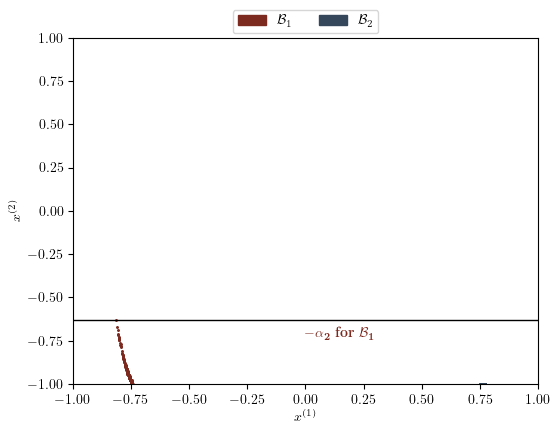

In [127]:
# topic 2
# bubble 1
# tfB1_t2 (alpha 2)
timing = tfB1_t2
name = 'topic_2_Bubble_1_alpha_2.pdf'

ALPHA = alpha2_B1
plot_color = 'red'
signForText = -1 
signForLine = -1

sep = 0.1 
text_x = 0
text_y = -alpha2_B1 - sep

text = r'$\mathbf{-\alpha_2}$ \textbf{for} $\mathbf{' + '\mathcal{B}_1}$'

text_color = 'red' 
line = 'Horizontal'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


## Bubble 2

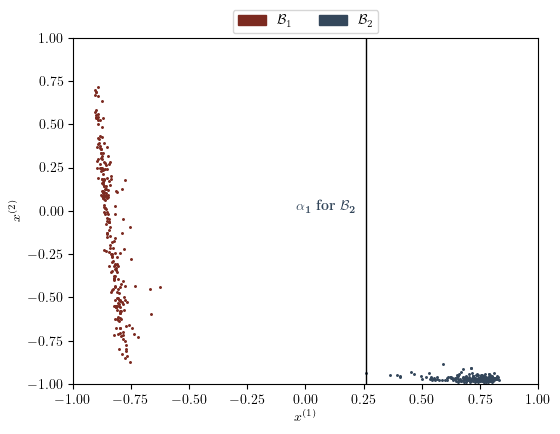

In [128]:
# topic 1
# bubble 2
# t0B1_t1 (alpha 1)

timing = t0B2_t1
name = 'topic_1_Bubble_2_alpha_1.pdf'

ALPHA = alpha1_B2
text_color = 'blue'
signForText = +1 
signForLine = +1

sep = 0.3
text_x = alpha1_B2 - sep
text_y = 0

text = r'$\mathbf{\alpha_1}$ \textbf{for} $\mathbf{' + '\mathcal{B}_2}$'

text_color = 'blue' 
line = 'Vertical'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


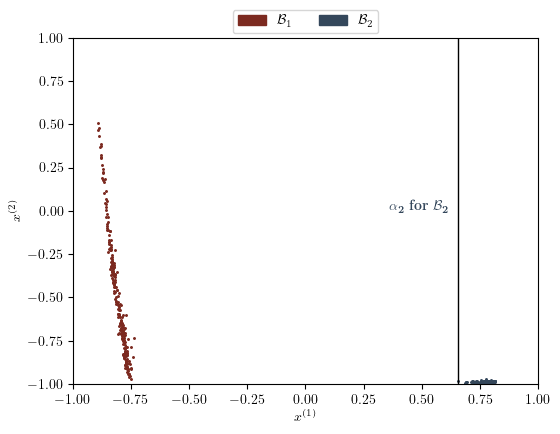

In [129]:
# topic 1
# bubble 2
# tfB2_t1 (alpha 2)

timing = tfB2_t1
name = 'topic_1_Bubble_2_alpha_2.pdf'

ALPHA = alpha2_B2
plot_color = 'blue'
signForText = +1 
signForLine = +1

sep = 0.3
text_x = alpha2_B2 - sep
text_y = 0

text = r'$\mathbf{\alpha_2}$ \textbf{for} $\mathbf{' + '\mathcal{B}_2}$'

text_color = 'blue' 
line = 'Vertical'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


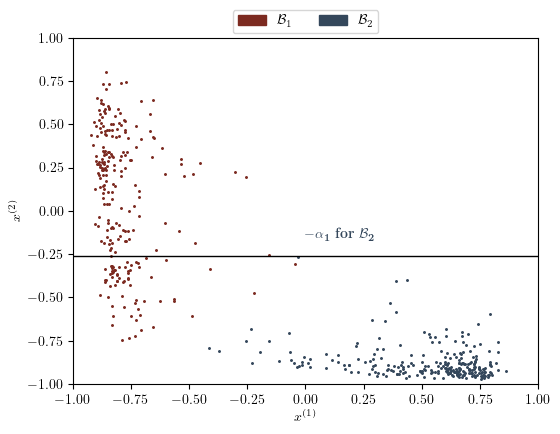

In [130]:
# topic 2
# bubble 2
# t0B2_t2 (alpha 1)

timing = t0B2_t2
name = 'topic_2_Bubble_2_alpha_1.pdf'

ALPHA = alpha1_B2
plot_color = 'blue'
signForText = -1 
signForLine = -1

sep = 0.1
text_x = 0
text_y = -alpha1_B2 + sep

text = r'$\mathbf{-\alpha_1}$ \textbf{for} $\mathbf{' + '\mathcal{B}_2}$'

text_color = 'blue' 
line = 'Horizontal'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


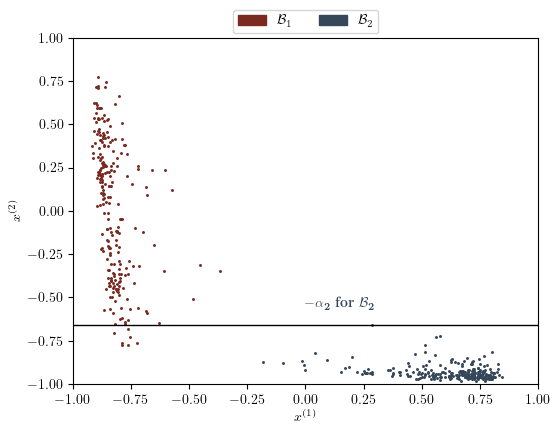

In [131]:
# topic 2
# bubble 2
# tfB2_t2 (alpha 2)

timing = tfB2_t2
name = 'topic_2_Bubble_2_alpha_2.pdf'

ALPHA = alpha2_B2
plot_color = 'blue'
signForText = -1 
signForLine = -1

sep = 0.1
text_x = 0
text_y = -alpha2_B2 + sep

text = r'$\mathbf{-\alpha_2}$ \textbf{for} $\mathbf{' + '\mathcal{B}_2}$'

text_color = 'blue' 
line = 'Horizontal'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


## Start or end

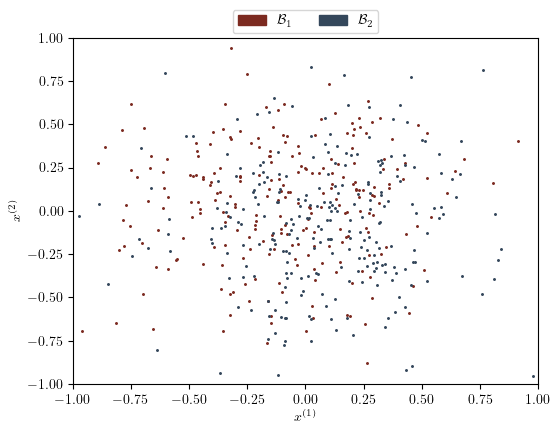

In [132]:
# start or end 

timing = 0
name = 'start.pdf'

ALPHA = alpha2_B1
plot_color = 'red'
signForText = +1 
signForLine = +1

text_x = 0.45 
text_y = 0

text = r'$\mathbf{\alpha_2}$ \textbf{for} $\mathbf{' + '\mathcal{B}_1}$'

text_color = 'red' 
line = 'Vertical'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


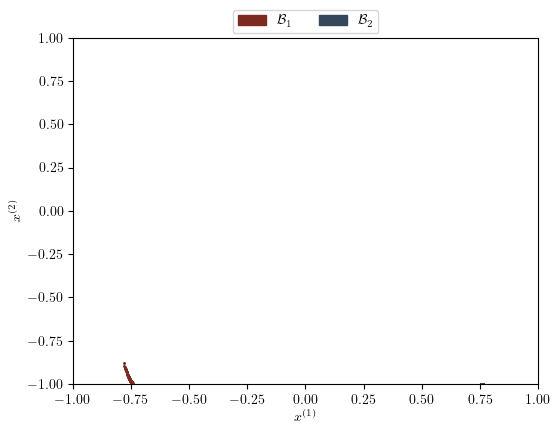

In [133]:
# start or end 

timing = 1000

name = 'end.pdf'

ALPHA = alpha2_B1
plot_color = 'red'
signForText = +1 
signForLine = +1

text_x = 0.45 
text_y = 0

text = r'$\mathbf{\alpha_2}$ \textbf{for} $\mathbf{' + '\mathcal{B}_1}$'

text_color = 'red' 
line = 'Vertical'

data_B1_dim_1 = bubble1_t1[timing][:]
data_B1_dim_2 = bubble1_t2[timing][:]

data_B2_dim_1 = bubble2_t1[timing][:]
data_B2_dim_2 = bubble2_t2[timing][:]

TwoDPlot(data_B1_dim_1, data_B1_dim_2, data_B2_dim_1, data_B2_dim_2, timing,
             name, ALPHA, signForText, signForLine, text_x, text_y, text_color, text, line)


# Save information

```
df1_t1 = pd.DataFrame(bubble1_t1)
df1_t1.to_csv(r'C:\Users\R\Desktop\Data\2d_model2.B1_topic_1.csv')

df2_t1 = pd.DataFrame(bubble2_t1)
df2_t1.to_csv(r'C:\Users\R\Desktop\Data\2d_model2.B2_topic_1.csv')

df1_t2 = pd.DataFrame(bubble1_t2)
df1_t2.to_csv(r'C:\Users\R\Desktop\Data\2d_model2.B1_topic_2.csv')

df2_t2 = pd.DataFrame(bubble2_t2)
df2_t2.to_csv(r'C:\Users\R\Desktop\Data\2d_model2.B2_topic_2.csv')
```

In [135]:
general_info = {'total-nodes': NodesNum, 'pG':pG, 'pL': pL, 'B1': s1, 'B2':(NodesNum - s1), 
               'alpha1-B1': alpha1_B1, 'alpha2-B1': alpha2_B1, 
                'alpha1-B2': alpha1_B2, 'alpha2-B2': alpha2_B2, 
               'total-time': t, 'WeightCoeff': WeightCoeff, 'd': d, 'beta':beta, 'GammaB1': GammaB1, 
               'GammaB2': GammaB2} 
general_info

{'total-nodes': 500,
 'pG': 0.062429216196844384,
 'pL': 0.8,
 'B1': 243,
 'B2': 257,
 'alpha1-B1': 0.2849,
 'alpha2-B1': 0.631,
 'alpha1-B2': 0.2615,
 'alpha2-B2': 0.6577,
 'total-time': 1000,
 'WeightCoeff': 0.018,
 'd': 0.2,
 'beta': 1,
 'GammaB1': 4.6,
 'GammaB2': 4.8}

In [136]:
general_info_df = pd.DataFrame(data = list(general_info.values()), index = list(general_info.keys()),
                               columns = ['general information'])
general_info_df

,general information
total-nodes,500.000000
pG,0.062429
pL,0.800000
B1,243.000000
B2,257.000000
alpha1-B1,0.284900
alpha2-B1,0.631000
alpha1-B2,0.261500
alpha2-B2,0.657700
total-time,1000.000000


In [137]:
topic_info = {'mu-B1-topic 1': mu_d1[0],
              'mu-B2-topic 1': mu_d1[1],
              'sigma2-B1-topic 1': sigma2_d1_B1,
              'sigma2-B2-topic 1': sigma2_d1_B2,
              
              'mu-B1-topic 2': mu_d2[0],
              'mu-B2-topic 2': mu_d2[1],
              'sigma2-B1-topic 2': sigma2_d2_B1,
              'sigma2-B2-topic 2': sigma2_d2_B2,
              
              't0-B1-topic 1': t0B1_t1, 
              't0-B2-topic 1': t0B2_t1, 
              'tf-B1-topic 1': tfB1_t1, 
              'tf-B2-topic 1': tfB2_t1, 
              
              't0-B1-topic 2': t0B1_t2, 
              't0-B2-topic 2': t0B2_t2, 
              'tf-B1-topic 2': tfB1_t2, 
              'tf-B2-topic 2': tfB2_t2,
              
             }
topic_info

{'mu-B1-topic 1': -0.09,
 'mu-B2-topic 1': 0.08,
 'sigma2-B1-topic 1': 0.12,
 'sigma2-B2-topic 1': 0.14,
 'mu-B1-topic 2': 0.07,
 'mu-B2-topic 2': -0.09,
 'sigma2-B1-topic 2': 0.14,
 'sigma2-B2-topic 2': 0.13,
 't0-B1-topic 1': 504,
 't0-B2-topic 1': 614,
 'tf-B1-topic 1': 619,
 'tf-B2-topic 1': 748,
 't0-B1-topic 2': 873,
 't0-B2-topic 2': 455,
 'tf-B1-topic 2': 925,
 'tf-B2-topic 2': 522}

In [138]:
topic_info_df = pd.DataFrame(data = list(topic_info.values()), index = list(topic_info.keys()),
                               columns = ['topic infomation'])
topic_info_df

,topic infomation
mu-B1-topic 1,-0.09
mu-B2-topic 1,0.08
sigma2-B1-topic 1,0.12
sigma2-B2-topic 1,0.14
mu-B1-topic 2,0.07
mu-B2-topic 2,-0.09
sigma2-B1-topic 2,0.14
sigma2-B2-topic 2,0.13
t0-B1-topic 1,504.00
t0-B2-topic 1,614.00


```
topic_info_df.to_csv('topic_info_df.csv')
general_info_df.to_csv('general_info_df.csv')
```